#### Kaggle competition

Label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond


#### What the data looks like ? 
Train-jpg: 40K+ satelite photos <br>
train_v2: (image_name, tags) Unique tags 449 <br>
So this is a multilabel image classification problem

#### Challenge
Unlike dog and cat image recognition, the image set are very similar in colors


In [1]:
from __future__ import division
from scipy.integrate import cumtrapz
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob, os
import cv2

In [2]:
# kaggle_path = '/home/ubuntu/.kaggle/competitions/planet-understanding-the-amazon-from-space/'
kaggle_path = '/Users/mumuxi/.kaggle/competitions/planet-understanding-the-amazon-from-space/'
labels = pd.read_csv('train_v2.csv')
print ('Number of unique tags',len(labels['tags'].unique()))
labels.head(5)

Number of unique tags 449


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


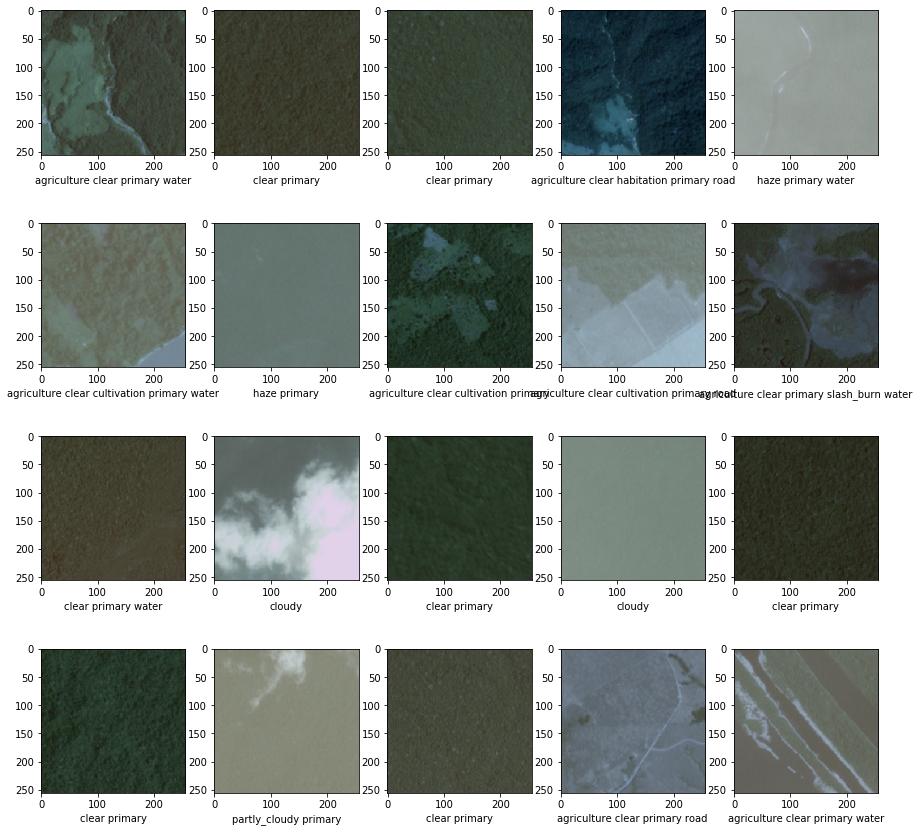

In [3]:
def example_photos(rows,columns):
    fig=plt.figure(figsize=(15, 15))
    for i in range(1, columns*rows +1):
        path = kaggle_path+f'train-jpg/train_{i}.jpg'
        img = cv2.imread(path)
        ax = fig.add_subplot(rows, columns, i)
        ax.set_xlabel(labels.tags[i])
        plt.imshow(img)
example_photos(rows=4,columns=5)

#### Evaluation - F2 SCORE
F2 is used to evaluate how good the model is and has a formula given below

$F_{2} = (1+β^{2})\frac{pr}{β^{2}p+r}$


,where *p* is precision, *r* is recall and β=2 

###  Tags EDA
- Most tags contains primary
- Clear has strong negative correlations with cloudy, haze, partly 

In [4]:
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets, model_selection, preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

/Users/mumuxi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
texts = labels.tags.tolist()
tokenizer = Tokenizer(filters='"#()*+,-./:;<=>?@[\]^`{|}~')
tokenizer.fit_on_texts(texts)

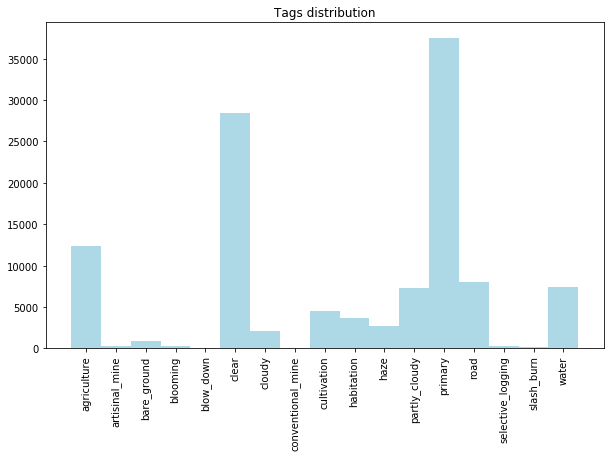

In [6]:
def plot_tags(tags):
    fig=plt.figure(figsize=(10, 6))
    plt.bar(tags.keys(), tags.values(), 1, color='lightblue')
    plt.xticks(rotation=90)
    plt.title('Tags distribution')
plot_tags(tokenizer.word_docs)

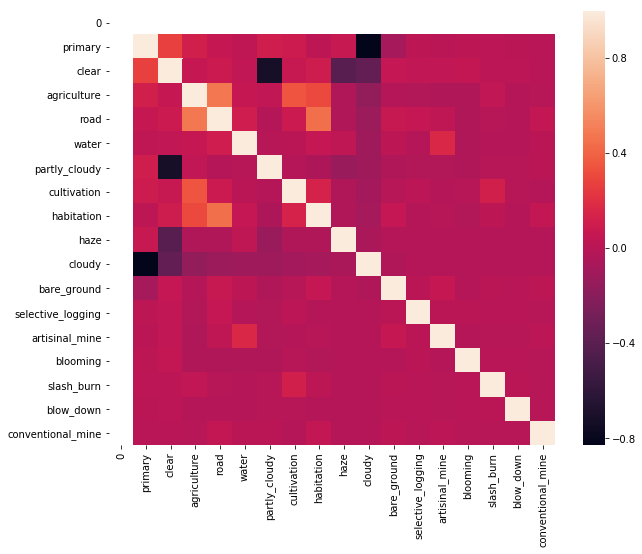

In [7]:
def count_vectorizer(M):
    df = pd.DataFrame(data=M,columns=['0']+list(tokenizer.word_index.keys()))
    corr = df.corr()
    fig=plt.figure(figsize=(10, 8))
    sns.heatmap(corr)
    df['image_name'] = labels.image_name
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[1:-1]
    df = df[cols]
    return df
df_t = count_vectorizer(tokenizer.texts_to_matrix(texts, mode='count'))

In [8]:
haze_id = df_t.loc[df_t['haze']==1,'image_name'].index.values
clear_id = df_t.loc[df_t['clear']==1,'image_name'].index.values
print ('haze vs clear ',len(haze_id),' : ',len(clear_id))

haze vs clear  2697  :  28431


### 1. Dehaze images
Source: [Single Image Haze Removal Using Dark Channel Prior](https://www.robots.ox.ac.uk/~vgg/rg/papers/hazeremoval.pdf)

The following formula is widely used to describe the formation of a haze image

$I(x) = J(x)t(x) + A(1-t(x))$

where *I* is the observed intensity, *J* represents the original haze-free image to be recovered, *A* is the global atmospheric light, and *t* is an exponential decay distribution .

The aim is to recover *J* from *I*. We can achieve that by tuning *t*, as *t* has a formula of

$t(x) = 1- w\times min[min(\frac{I_{c}(y)}{A^{c}})]$
,where *w* is weight coefficient, *c* is the dark channel color (darkest channel of RGB channel)

In [9]:
"""Single image dehazing."""
class Channel_value:
    val = -1.0
    intensity = -1.0

def find_intensity_of_atmospheric_light(img, gray):
    """return Atomospheric light A """
    # pick top 0.1% brightest pixels in the dark channel ~ most hazeopaque
    top_num = int(img.shape[0] * img.shape[1] * 0.001)
    toplist = [Channel_value()] * top_num 
    dark_channel = find_dark_channel(img)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            val = img.item(y, x, dark_channel)
            intensity = gray.item(y, x)
            for t in toplist:  # create 65 different channels 
                if t.val < val or (t.val == val and t.intensity < intensity):
                    t.val = val
                    t.intensity = intensity
                    break
    max_channel = Channel_value()
    for t in toplist:
        if t.intensity > max_channel.intensity:
            max_channel = t
    return max_channel.intensity

def find_dark_channel(img): #get darkest RBG channel
    return np.unravel_index(np.argmin(img), img.shape)[2]

def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))

def dehaze(img, light_intensity, windowSize, t0, w):
    size = (img.shape[0], img.shape[1])
    outimg = np.zeros(img.shape, img.dtype)
    for y in range(size[0]):
        for x in range(size[1]):
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), size[1])
            y_high = min(y+(windowSize//2), size[0])
            sliceimg = img[y_low:y_high, x_low:x_high]
            dark_channel = find_dark_channel(sliceimg)
            t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity)
            outimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,2), clamp(0, ((img.item(y,x,2) - light_intensity) / max(t, t0) + light_intensity), 255))
    return outimg


def dehaze_image(path,w = 0.95, t0 = 0.55):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #image to gray scale
    light_intensity = find_intensity_of_atmospheric_light(img, gray)
    outimg = dehaze(img, light_intensity, 20, t0, w)
    return outimg

def example_photo_no(path):
    img = cv2.imread(path)
    plt.imshow(img)
    
def intensity_plot(path):
    img = cv2.imread(path)
    color = ('b','g','r')
    histr = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.plot(histr)
## %%%%%%%%      GRB PLOT   %%%%%%%%
#     for i,col in enumerate(color):
#         histr = cv2.calcHist([img],[i],None,[256],[0,256])
#         plt.plot(histr,color = col)
#         plt.xlim([0,256])
# ##  %%%%%%%     CDF plot    %%%%%%%%
#     values, bins = np.histogram(img.ravel(),256,[0,256],normed=True)
#     cum = np.cumsum(values)
#     plt.plot(bins[:-1],cum)

def compare_photos(image_id):
    path = kaggle_path+f'train-jpg/train_{image_id}.jpg'
    fig=plt.figure(figsize=(5, 8))
    ax1 = fig.add_subplot(211)
    dehazed_img = dehaze_image(path)
    plt.imshow(dehazed_img)
    fig.add_subplot(212,sharex=ax1)
    example_photo_no(path)
    plt.show()

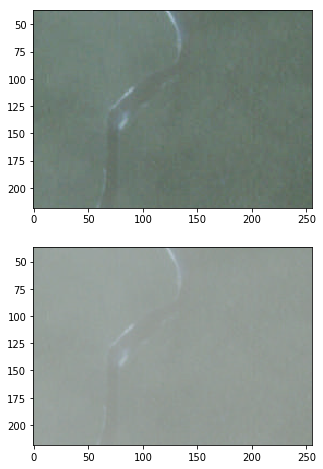

In [10]:
compare_photos(5)

### Logistic Regression 
- Distiguish haze | clear label

### 1 Neural Network vanilla model
- Importing the Keras libraries and packages
- Sequential:<br> initialise model as a sequential network. There are two basic ways of initialising a neural network, either by a sequence of layers or as a graph

#### 1.1 Model Work Flow
1. **Conv2D** 
    - Images => 2 D arrays
    - Videos => Convolution 3-D 
    
    
2. **MaxPooling2D**:<br> The primary aim of a pooling operation is to reduce the size of the images. Different types of pooling operations like Min Pooling, Mean Pooling, etc. Here in MaxPooling we need the maximum value pixel from the respective region of interest.


3. **Flatten**:<br> Flattening is the process of converting all the resultant 2 dimensional arrays into a continuous vector.


4. **Dense** 
    - units: no nodes in the hidden layer
5. **compile**
    - Optimizer:  stochastic gradient descent algorithm
    - Loss: loss function
    - Metrics: performance metric

In [11]:
def load_train_data(N,start=0):
    img_L = []
    for i in range(start,N):
        img = cv2.imread(kaggle_path+f'train-jpg/train_{i}.jpg')
        img_L.append(img)
    return np.array(img_L),df_t.iloc[start:N,1::]

def load_test_data(N,start=0):
    img_L = []
    for i in range(start,N):
        img = cv2.imread(kaggle_path+f'test-jpg/test_{i}.jpg')
        img_L.append(img)
    return np.array(img_L),df_t.iloc[start:N,1::]

X_train,y_train = load_train_data(1000)
X_test,y_test = load_train_data(5500,5000)
X_val,y_val = load_test_data(100)

In [12]:
no_features = 17
print (X_test.shape,y_test.shape)

(500, 256, 256, 3) (500, 17)


32 filters of size 12x12<br>
input image size 256 x 256, 3 for RGB

In [13]:
import keras.backend as K

def F2_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return (1+4)*precision*recall/(4*precision+recall)
    

In [14]:
classifier = Sequential()
classifier.add(Conv2D(32, kernel_size=(12,12), 
               activation = 'relu',
               input_shape = (256, 256, 3), 
               ))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = no_features, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', 
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy',F2_score])

In [15]:
classifier.fit(X_train, y_train, epochs=1, batch_size=200)

Epoch 1/1
1000/1000 [==============================] - 770s 770ms/step - loss: 5.3558 - acc: 0.6481 - F2_score: 0.4145


#### 1.2 Pre-processing image
The directory name is taken as the label of all the images present in it.

In [17]:
score = classifier.evaluate(X_test, y_test, verbose=0)
print('Test loss: %.3f  accuracy: %.3f F2 score: %.3f.' %(score[0],score[1],score[2]))
score = classifier.evaluate(X_val, y_val, verbose=0)
print('Val loss: %.3f  accuracy: %.3f F2 score: %.3f.' %(score[0],score[1],score[2]))



Test loss: 2.693  accuracy: 0.832 F2 score: 0.648.
Val loss: 2.729  accuracy: 0.829 F2 score: 0.642.
